<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,.,.,.,a,1,.,.
B,b,.,.,a,.,a,.,.,.,.
C,1,.,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,.
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,1
H,.,c,.,b,.,.,.,.,.,.
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 0 Puntos:116
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,.,.,.,a,1,.,.
B,b,.,.,a,.,a,.,.,.,.
C,2,a,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,.
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,1
H,.,c,.,b,.,.,.,.,.,.
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 1 Puntos:137
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,a,.,1,.
B,b,.,.,a,.,a,.,.,.,.
C,2,a,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,.
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,.
H,.,c,.,b,.,.,.,.,.,1
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 2 Puntos:138
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,a,.,.,1
B,b,.,.,a,.,a,.,.,.,.
C,2,a,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,1
H,.,c,.,b,.,.,.,.,.,.
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 3 Puntos:133
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,a,a,.,.
B,b,.,.,a,.,a,.,.,.,1
C,2,a,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,.
H,.,c,.,b,.,.,.,.,.,1
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 4 Puntos:134
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,1
B,b,.,.,a,.,a,.,.,.,.
C,2,a,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,1
H,.,c,.,b,.,.,.,.,.,.
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 5 Puntos:137
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,.,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,.
H,.,c,.,b,.,.,.,.,.,1
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 6 Puntos:158
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,c,a,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,1
H,.,c,.,b,.,.,.,.,.,.
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 7 Puntos:159
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,a,.,a,.,a,.,.,b,.
C,2,a,.,.,.,a,.,c,.,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,.
H,.,c,.,b,.,.,.,.,.,1
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 8 Puntos:162
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,a,.,a,.,a,.,.,b,a
C,2,a,.,.,.,a,.,c,.,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,.,.,a,.,a,.,.,.,a
G,.,c,c,a,a,.,a,.,.,1
H,.,c,.,b,.,.,.,.,.,.
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 9 Puntos:163
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,a,.,a,.,a,.,.,b,a
C,2,a,.,.,.,a,.,c,.,.
D,a,.,.,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,.
H,.,.,.,b,.,.,.,.,.,1
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 10 Puntos:213
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,a,.,a,.,a,.,.,b,a
C,2,a,.,.,.,a,.,c,.,.
D,a,.,a,a,.,.,.,.,.,a
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,1
H,.,.,.,b,.,.,.,.,.,.
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 11 Puntos:214
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,a,.,a,.,a,.,.,b,a
C,2,a,.,.,.,a,.,c,.,.
D,a,.,a,a,.,.,.,.,a,a
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,.,1
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 12 Puntos:165
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,b,2
B,b,a,.,a,.,a,.,.,b,a
C,2,a,.,.,.,a,.,c,.,.
D,a,.,a,a,.,.,.,.,a,a
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 13 Puntos:186
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,.,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,c,c,.
D,a,.,a,a,.,.,.,.,.,.
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 14 Puntos:199
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,.,.,a,.,.,.,.,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,c,c,.
D,a,.,a,a,.,.,.,.,.,.
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 15 Puntos:200
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,.,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,c,c,.
D,a,.,a,a,.,.,.,.,.,.
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 16 Puntos:205
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,.,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,c,c,.
D,a,.,a,a,.,.,.,.,b,.
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 17 Puntos:210
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,c,c,.
D,a,.,a,a,.,.,.,.,b,.
E,a,a,c,.,.,.,.,.,b,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 18 Puntos:211
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,.
D,a,.,a,a,.,.,.,d,.,.
E,a,a,c,.,.,.,.,.,.,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 19 Puntos:276
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,.,a,a,.,.,.,d,.,.
E,a,a,c,.,.,.,.,.,.,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 20 Puntos:277
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,.,a,a,.,.,.,d,.,b
E,a,a,c,.,.,.,.,.,.,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 21 Puntos:282
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,.,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 22 Puntos:283
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,.,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 23 Puntos:284
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 24 Puntos:279
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,.,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 25 Puntos:280
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,.,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 26 Puntos:281
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 27 Puntos:286
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,a,.,.,.,a
J,.,.,.,a,.,a,b,.,c,.



Turno: 28 Puntos:287
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,b,.,.,a
J,.,.,.,a,.,.,b,.,c,.



Turno: 29 Puntos:290
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,b,.,.,a
J,.,.,.,a,.,.,b,.,c,a



Turno: 30 Puntos:291
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,b,.,.,a,.,.,.,a,a,2
B,b,a,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 31 Puntos:306
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,c,.,a,.,.,.,a,a,2
B,.,.,.,a,.,a,.,.,.,a
C,2,.,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 32 Puntos:319
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,c,.,a,.,.,.,a,a,2
B,a,.,.,a,.,a,.,.,.,a
C,2,.,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 33 Puntos:320
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,.,.,.,a,a,2
B,a,.,.,a,.,a,.,.,.,a
C,2,.,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 34 Puntos:321
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,.,.,.,a,a,2
B,a,.,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,.,a,a,.,a,a,.,x
H,.,.,b,b,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 35 Puntos:322
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,.,.,.,a,a,2
B,a,.,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,.,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,x
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 36 Puntos:337
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,.,.,.,a,a,2
B,a,.,.,a,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,x
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 37 Puntos:332
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,.,.,.,.,a,a,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,x
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 38 Puntos:335
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,.,.,.,a,a,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,x
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 39 Puntos:336
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,1,.,.,a,a,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,x
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 40 Puntos:311
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,.,1,b,.,.,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,x
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 41 Puntos:314
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,.,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,x
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 42 Puntos:335
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,.,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,.
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 43 Puntos:385
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,b,.,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,.
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 44 Puntos:390
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,.,.,c,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,.
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 45 Puntos:405
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,.,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,.
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 46 Puntos:410
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,.,b,.,.,a
C,2,a,.,.,.,.,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,.
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 47 Puntos:413
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,.,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,.
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 48 Puntos:414
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,.
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 49 Puntos:415
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,a,a,.,1
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 50 Puntos:390
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,.,b,2
H,.,.,.,.,.,.,.,.,.,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 51 Puntos:412
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,.,b,2
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 52 Puntos:413
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,.,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 53 Puntos:414
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,.,.,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 54 Puntos:417
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,.,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 55 Puntos:418
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,b,.,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 56 Puntos:419
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,.,.,c,2
B,a,.,.,.,.,.,.,.,.,a
C,2,a,.,.,.,.,c,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 57 Puntos:432
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,a,.,c,2
B,a,.,.,.,.,.,.,.,.,a
C,2,a,.,.,.,.,c,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 58 Puntos:433
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,a,a,c,2
B,a,.,.,.,.,.,.,.,.,a
C,2,a,.,.,.,.,c,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 59 Puntos:434
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,a,a,c,2
B,a,.,.,.,.,1,.,.,.,a
C,2,a,.,.,.,.,c,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 60 Puntos:409
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,.,.,c,2
B,a,.,.,.,.,.,1,b,.,a
C,2,a,.,.,.,.,c,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 61 Puntos:412
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,1,.,b,.,a
C,2,a,.,.,.,.,c,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 62 Puntos:417
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,.,1,b,b,.
C,2,a,.,.,.,.,c,.,.,.
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 63 Puntos:420
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,2,b,b,.
C,2,a,.,.,.,.,c,.,.,.
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 64 Puntos:441
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,2,b,b,a
C,2,a,.,.,.,.,c,.,.,.
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 65 Puntos:442
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,2,b,b,a
C,2,a,.,.,.,a,c,.,.,.
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 66 Puntos:443
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,2,b,b,a
C,2,a,.,.,.,a,c,.,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,.,a
G,.,.,c,a,a,.,.,b,b,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 67 Puntos:444
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,2,b,b,a
C,2,a,.,.,.,a,c,.,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 68 Puntos:456
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,2,.,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 69 Puntos:471
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,.,c,2
B,a,.,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 70 Puntos:472
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,b,c,2
B,a,.,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 71 Puntos:477
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,c,b,a,a,2,b,b,c,2
B,a,.,b,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 72 Puntos:482
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,c,.,a,a,2,b,b,c,2
B,.,c,.,.,.,a,2,a,.,a
C,2,.,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 73 Puntos:494
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,.,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 74 Puntos:495
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,.,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 75 Puntos:496
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 76 Puntos:497
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 77 Puntos:498
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,2
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,2
H,.,.,.,.,.,.,.,a,a,2
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 78 Puntos:499
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,a,b
E,a,a,c,.,.,a,.,.,a,.
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 79 Puntos:564
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,c,c,.,a
D,a,2,a,a,.,.,.,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 80 Puntos:567
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,a,2,a,.,a
C,2,a,.,.,.,a,.,.,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 81 Puntos:642
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,.,2,a,.,a
C,2,a,.,.,.,.,b,.,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 82 Puntos:645
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,1,2,a,.,a
C,2,a,.,.,.,.,b,.,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 83 Puntos:620
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,c,.,a,a,2,b,b,c,2
B,a,c,.,.,.,.,2,a,.,a
C,2,a,.,.,a,1,b,.,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 84 Puntos:621
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,.,.,.,1,2,a,.,a
C,2,a,.,.,a,.,b,.,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 85 Puntos:696
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,.,.,1,.,2,a,.,a
C,2,a,.,.,a,a,b,.,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 86 Puntos:697
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,.,1,.,1,2,a,.,a
C,2,a,.,.,a,a,b,.,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 87 Puntos:672
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,.,.,1,1,2,a,.,a
C,2,a,.,.,a,a,b,a,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 88 Puntos:673
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,1,1,.,2,a,.,a
C,2,a,.,.,a,a,b,a,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 89 Puntos:674
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,.,b,2,a,.,a
C,2,a,.,1,1,.,b,a,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 90 Puntos:677
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,1,1,b,2,a,.,a
C,2,a,1,.,.,.,b,a,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 91 Puntos:652
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,1,b,2,a,.,a
C,2,a,1,1,1,.,b,a,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 92 Puntos:627
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,1,.,b,2,a,.,a
C,2,a,1,1,1,1,b,a,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 93 Puntos:602
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,.,b,2,a,.,a
C,2,a,1,1,1,1,b,a,.,a
D,a,2,a,a,.,.,d,d,.,b
E,a,a,c,.,.,a,.,.,.,b
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 94 Puntos:627
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,1,1,b,2,a,.,a
C,2,a,1,.,.,.,b,a,.,a
D,a,2,a,a,.,1,d,d,.,.
E,a,a,c,.,.,a,.,.,c,.
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 95 Puntos:642
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,.,b,2,a,.,a
C,2,a,x,3,a,1,b,a,.,a
D,a,2,a,a,.,.,d,d,.,.
E,a,a,c,.,.,a,.,.,c,.
F,a,d,2,a,.,a,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 96 Puntos:718
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,.,b,2,a,.,a
C,2,a,x,3,a,2,b,a,.,a
D,a,2,a,a,.,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 97 Puntos:741
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,.,.,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,x,3,.,2,b,a,.,a
D,a,2,a,a,.,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 98 Puntos:743
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,.,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,x,3,.,2,b,a,.,a
D,a,2,a,a,.,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 99 Puntos:744
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,x,3,.,2,b,a,.,a
D,a,2,a,a,.,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 100 Puntos:745
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,x,3,a,2,b,a,.,a
D,a,2,a,a,.,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 101 Puntos:746
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,a,a,.,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 102 Puntos:796
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,.,3,.,2,b,a,.,a
D,a,2,.,.,b,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 103 Puntos:798
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,.,.,b,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 104 Puntos:799
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,b,.,b,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 105 Puntos:804
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,a,.,b,b,2,a,.,a
C,2,a,b,3,a,2,b,a,.,a
D,a,2,b,.,b,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 106 Puntos:809
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,.,.,2,b,b,c,2
B,a,.,.,c,.,.,2,a,.,a
C,2,a,b,3,a,2,b,a,.,a
D,a,2,b,.,b,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 107 Puntos:821
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,.,.,2,b,b,c,2
B,a,.,c,c,.,.,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,.,.,b,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 108 Puntos:836
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,.,a,2,b,b,c,2
B,a,.,c,c,.,.,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,.,.,b,b,d,d,.,.
E,a,a,c,.,.,.,.,.,c,.
F,a,d,2,a,.,.,.,.,c,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 109 Puntos:837
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,.,a,2,b,b,c,2
B,a,.,c,c,.,.,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,.,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 110 Puntos:1162
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,c,c,.,.,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,.,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 111 Puntos:1163
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,c,c,.,a,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,.,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 112 Puntos:1164
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,.,c,c,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,.,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 113 Puntos:1165
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,.,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 114 Puntos:1240
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,.,.,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 115 Puntos:1243
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,.,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 116 Puntos:1244
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,.,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 117 Puntos:1245
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,b,d,a,a,2,b,b,c,2
B,.,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 118 Puntos:1248
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,.,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 119 Puntos:1249
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 120 Puntos:1250
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,.,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 121 Puntos:1249
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,b,b,.,.,e,.
E,a,a,c,.,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 122 Puntos:1250
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,.,.,.,.,e,.
E,a,a,c,.,c,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 123 Puntos:1265
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,a,2,b,a,.,a
D,a,2,b,.,a,.,.,.,e,.
E,a,a,c,.,c,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 124 Puntos:1266
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,.,2,b,a,.,a
D,a,2,b,b,.,.,.,.,e,.
E,a,a,c,.,c,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,a,a,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 125 Puntos:1269
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,.,2,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 126 Puntos:1331
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,.,.,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 127 Puntos:1336
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 128 Puntos:1337
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,.,.,.,a,2,a,.,a
C,2,a,a,3,.,a,b,a,.,a
D,a,2,1,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 129 Puntos:1312
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,a,2,b,b,c,2
B,a,d,b,.,.,a,2,a,.,a
C,2,.,1,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 130 Puntos:1315
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,.,.,2,b,b,c,2
B,a,d,b,b,.,a,2,a,.,a
C,2,.,.,3,.,a,b,a,.,a
D,a,2,1,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 131 Puntos:1318
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,.,1,2,b,b,c,2
B,a,d,b,b,.,a,2,a,.,a
C,2,.,1,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 132 Puntos:1293
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,.,.,2,b,b,c,2
B,a,d,b,b,1,a,2,a,.,a
C,2,a,.,3,.,a,b,a,.,a
D,a,2,1,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 133 Puntos:1294
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,1,2,b,b,c,2
B,a,d,b,b,.,a,2,a,.,a
C,2,a,1,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 134 Puntos:1295
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,1,.,c,a,2,a,.,a
C,2,a,.,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 135 Puntos:1330
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,.,a,c,a,2,a,.,a
C,2,a,1,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 136 Puntos:1331
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,1,a,c,a,2,a,.,a
C,2,a,.,3,.,a,b,a,.,a
D,a,2,a,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 137 Puntos:1332
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,.,b,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 138 Puntos:1355
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,.,a,b,a,.,a
D,a,2,.,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 139 Puntos:1356
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,.,a,b,a,.,a
D,a,2,1,.,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 140 Puntos:1331
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,.,a,b,a,.,a
D,a,2,.,1,1,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 141 Puntos:1306
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,1,a,b,a,.,a
D,a,2,a,1,.,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 142 Puntos:1307
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 143 Puntos:1372
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 144 Puntos:1373
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,2,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 145 Puntos:1374
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,.,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 146 Puntos:1379
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,.,b,2,b,b,c,2
B,a,d,2,.,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,.,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 147 Puntos:1382
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,.,b,2,b,b,c,2
B,a,d,2,.,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,2,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 148 Puntos:1377
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,.,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,2,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 149 Puntos:1378
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,a,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,2,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 150 Puntos:1379
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,.,2,a,.,a
C,2,a,b,3,2,.,b,a,.,a
D,a,2,a,2,c,b,.,.,e,.
E,a,a,2,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 151 Puntos:1382
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,.,b,a,.,a
D,a,2,a,2,c,b,.,.,e,.
E,a,a,2,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 152 Puntos:1383
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,b,.,.,e,.
E,a,a,2,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 153 Puntos:1378
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,b,a,.,e,.
E,a,a,2,d,.,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 154 Puntos:1379
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,b,a,.,e,.
E,a,a,2,d,.,.,a,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 155 Puntos:1380
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,b,.,.,e,.
E,a,a,2,d,.,b,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 156 Puntos:1383
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,.,.,.,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 157 Puntos:1396
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,a,.,.,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 158 Puntos:1397
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,a,a,.,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,.,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 159 Puntos:1398
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,a,a,.,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,.,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 160 Puntos:1399
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,.,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,a,a,.,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 161 Puntos:1400
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,1,a
C,2,a,b,3,2,2,b,a,.,a
D,a,2,a,2,c,a,a,.,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 162 Puntos:1375
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,2,a
C,2,a,b,3,2,2,b,a,2,a
D,a,2,a,2,c,a,a,.,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 163 Puntos:1390
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,2,.
C,2,a,b,3,2,2,b,a,2,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 164 Puntos:1393
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,2
B,a,d,2,a,c,a,2,a,2,1
C,2,a,b,3,2,2,b,a,2,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 165 Puntos:1368
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,2,a,.,.
C,2,a,b,3,2,2,b,a,.,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 166 Puntos:1458
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,2,.,b,.
C,2,a,b,3,2,2,b,.,.,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 167 Puntos:1461
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,2,a,b,.
C,2,a,b,3,2,2,b,.,.,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 168 Puntos:1462
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,2,a,b,.
C,2,a,b,3,2,2,b,a,.,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 169 Puntos:1463
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,2,a,b,b
C,2,a,b,3,2,2,b,a,.,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 170 Puntos:1468
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,2,.,.,.
C,2,a,b,3,2,2,b,.,c,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 171 Puntos:1481
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,.,.,.,.
C,2,a,b,3,2,2,b,.,c,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 172 Puntos:1486
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,.,.,.
C,2,a,b,3,2,2,b,.,c,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 173 Puntos:1487
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,.,.,.
C,2,a,b,3,2,2,b,b,c,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 174 Puntos:1492
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,1,.,.
C,2,a,b,3,2,2,b,b,c,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 175 Puntos:1467
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,.
C,2,a,b,3,2,2,b,b,c,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 176 Puntos:1488
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,2,2,b,b,c,.
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 177 Puntos:1489
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,.,.
C,2,a,b,3,2,2,b,b,c,b
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 178 Puntos:1492
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,.
C,2,a,b,3,2,2,b,b,c,b
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 179 Puntos:1493
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,.
C,2,a,b,3,.,2,b,b,c,b
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 180 Puntos:1498
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,.,2,b,b,c,b
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 181 Puntos:1499
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,b,b,c,b
D,a,2,a,2,c,a,a,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 182 Puntos:1500
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,.,.,c,b
D,a,2,a,2,c,.,.,c,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 183 Puntos:1513
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,.,.,2,a,a
C,2,a,b,3,a,2,b,.,c,b
D,a,2,a,2,c,.,.,c,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 184 Puntos:1516
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,.,.,2,a,a
C,2,a,b,3,a,2,b,d,.,b
D,a,2,a,2,c,.,.,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 185 Puntos:1591
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,.,2,a,a
C,2,a,b,3,a,2,b,d,.,b
D,a,2,a,2,c,.,.,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 186 Puntos:1592
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,b,d,.,b
D,a,2,a,2,c,.,.,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 187 Puntos:1593
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,b,d,.,b
D,a,2,a,2,c,a,.,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 188 Puntos:1594
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,b,d,.,b
D,a,2,a,2,c,a,b,.,e,b
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 189 Puntos:1599
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,b,d,.,b
D,a,2,a,2,c,a,b,.,e,b
E,a,a,2,d,c,a,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 190 Puntos:1600
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,.,.
C,2,a,b,3,a,2,b,d,c,.
D,a,2,a,2,c,a,b,.,e,.
E,a,a,2,d,c,a,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 191 Puntos:1613
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,.
C,2,a,b,3,a,2,b,d,c,.
D,a,2,a,2,c,a,b,.,e,.
E,a,a,2,d,c,a,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 192 Puntos:1614
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,.
C,2,a,b,3,a,2,.,d,c,.
D,a,2,a,2,c,a,.,c,e,.
E,a,a,2,d,c,a,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 193 Puntos:1629
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,.,d,c,.
D,a,2,a,2,c,a,.,c,e,.
E,a,a,2,d,c,a,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 194 Puntos:1630
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,1,d,c,.
D,a,2,a,2,c,a,.,c,e,.
E,a,a,2,d,c,a,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 195 Puntos:1605
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,c,.,b,c,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 196 Puntos:1628
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,c,a,b,c,e,.
E,a,a,2,d,c,.,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 197 Puntos:1629
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,c,a,b,c,e,.
E,a,a,2,d,c,a,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 198 Puntos:1630
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,c,.,b,c,e,.
E,a,a,2,d,c,.,b,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 199 Puntos:1633
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,c,a,b,c,e,.
E,a,a,2,d,c,.,b,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 200 Puntos:1634
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,.,a,.,c,e,.
E,a,a,2,d,.,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 201 Puntos:1699
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,.,2,2,d,c,.
D,a,2,a,2,b,.,.,c,e,.
E,a,a,2,d,.,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 202 Puntos:1702
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,b,.,.,c,e,.
E,a,a,2,d,.,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 203 Puntos:1703
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,b,.,.,c,e,.
E,a,a,2,d,2,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 204 Puntos:1698
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,b,a,.,c,e,.
E,a,a,2,d,2,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 205 Puntos:1699
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,.
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 206 Puntos:1700
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,.,.
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 207 Puntos:1703
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,.
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 208 Puntos:1704
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 209 Puntos:1705
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,.,.,.,.
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 210 Puntos:1706
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,.,.,.,a
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 211 Puntos:1707
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,.,.,c,e,a
E,a,a,2,d,2,d,b,.,.,a
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 212 Puntos:1710
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,.,c,e,a
E,a,a,2,d,2,d,b,.,.,a
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 213 Puntos:1711
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,b,.,.,a
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 214 Puntos:1712
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,b,a,.,a
F,a,d,2,a,a,.,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 215 Puntos:1713
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,b,a,.,a
F,a,d,2,a,a,.,.,a,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 216 Puntos:1714
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,b,.,.,a
F,a,d,2,a,a,.,b,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 217 Puntos:1717
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,.,.,.,a
F,a,d,2,.,.,c,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 218 Puntos:1730
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,.,.,.,a
F,a,d,2,a,.,c,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 219 Puntos:1731
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,.,.,.,a
F,a,d,2,a,a,c,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 220 Puntos:1732
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,1,.,.,a
F,a,d,2,a,a,c,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 221 Puntos:1707
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,.,1,b,.
F,a,d,2,a,a,c,.,.,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 222 Puntos:1710
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,.,.,b,.
F,a,d,2,a,a,c,1,1,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 223 Puntos:1685
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,1,1,b,.
F,a,d,2,a,a,c,.,1,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 224 Puntos:1660
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,1,1,b,.
F,a,d,2,a,a,c,a,.,1,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 225 Puntos:1661
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,.
E,a,a,2,d,2,d,2,2,b,.
F,a,d,2,a,a,c,a,a,.,1
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 226 Puntos:1702
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,1
F,a,d,2,a,a,c,a,a,.,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 227 Puntos:1703
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,2,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,.,a
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 228 Puntos:1724
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,.,a
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 229 Puntos:1729
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,.,a
G,.,.,c,.,.,.,.,.,.,a
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 230 Puntos:1730
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,.,.,b,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 231 Puntos:1731
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,.,b,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 232 Puntos:1732
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,.
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 233 Puntos:1733
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,.,.,.,.
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 234 Puntos:1734
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,.,.,.,a
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,.,.,a
J,.,.,.,a,.,.,.,c,c,a



Turno: 235 Puntos:1735
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,.,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,.,.,.,a
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 236 Puntos:1810
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,.,.,.,a
H,.,.,.,.,.,.,.,a,a,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 237 Puntos:1815
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,.,2
F,a,d,2,a,a,c,a,a,.,.
G,.,.,c,.,.,.,.,.,c,.
H,.,.,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 238 Puntos:1826
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,.,.
G,.,.,c,.,.,.,.,.,c,.
H,.,.,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 239 Puntos:1831
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,.,.,b,.
G,.,.,c,.,.,.,.,.,c,.
H,.,.,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 240 Puntos:1834
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,1,.,b,.
G,.,.,c,.,.,.,.,.,c,.
H,.,.,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 241 Puntos:1809
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,.,a,b,.
G,.,.,c,.,.,.,1,.,c,.
H,.,.,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 242 Puntos:1810
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,.
G,.,.,c,.,.,.,.,1,c,.
H,.,.,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 243 Puntos:1811
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,.,.,c,.
H,.,.,.,.,.,.,.,1,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 244 Puntos:1812
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,b,1,c,.
H,.,.,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 245 Puntos:1817
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,b,2,c,.
H,.,.,.,.,.,.,.,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 246 Puntos:1838
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,b,2,c,a
H,.,.,.,.,.,.,.,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 247 Puntos:1839
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,.,b,2,c,a
H,.,.,.,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 248 Puntos:1840
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,1,.,c,.,.,.,b,2,c,a
H,.,.,.,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 249 Puntos:1815
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,1,c,.,.,b,b,2,c,a
H,.,.,.,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 250 Puntos:1820
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,b,b,2,c,a
H,a,1,.,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 251 Puntos:1821
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,1,c,.,.,b,b,2,c,a
H,a,.,.,.,.,.,a,a,.,3
I,a,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 252 Puntos:1822
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,a,c,a,a,b,a
G,.,.,c,.,.,b,b,2,c,a
H,a,1,a,.,.,.,a,a,.,3
I,a,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 253 Puntos:1823
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,.,.,c,a,a,b,a
G,.,1,c,.,c,.,.,2,c,a
H,a,.,a,.,.,.,a,a,.,3
I,a,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 254 Puntos:1836
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,.,c,a,a,b,a
G,.,.,c,.,c,.,.,2,c,a
H,a,1,a,.,.,.,a,a,.,3
I,a,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 255 Puntos:1837
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,d,.,a,a,b,a
G,.,1,c,.,.,.,.,2,c,a
H,a,.,a,.,.,.,a,a,.,3
I,a,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 256 Puntos:1912
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,d,.,a,a,b,a
G,.,.,c,a,.,.,.,2,c,a
H,a,1,a,.,.,.,a,a,.,3
I,a,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 257 Puntos:1913
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,d,.,a,a,b,a
G,b,1,c,a,.,.,.,2,c,a
H,a,.,a,.,.,.,a,a,.,3
I,a,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 258 Puntos:1918
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,d,.,a,a,b,a
G,b,2,c,a,.,.,.,2,c,a
H,.,b,.,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 259 Puntos:1940
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,d,.,.,.,b,a
G,b,2,c,a,.,.,b,2,c,a
H,.,b,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 260 Puntos:1941
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,b,2
F,a,d,2,a,d,.,a,.,b,a
G,b,2,c,a,.,.,b,2,c,a
H,.,b,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 261 Puntos:1942
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,.,2
F,a,d,2,a,d,.,a,c,.,a
G,b,2,c,a,.,.,b,2,c,a
H,.,b,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 262 Puntos:1957
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,.,a,c,.,a
G,b,2,c,a,.,.,b,2,c,a
H,.,b,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 263 Puntos:1958
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,.,a,c,.,a
G,b,2,c,a,.,b,b,2,c,a
H,.,b,.,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 264 Puntos:1963
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,.,a,c,.,a
G,b,2,c,a,.,b,b,2,c,a
H,.,b,b,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 265 Puntos:1968
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,a,a,c,.,a
G,b,2,c,a,.,b,b,2,c,a
H,.,b,b,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 266 Puntos:1969
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,a,a,c,.,a
G,b,2,c,a,.,b,b,2,c,a
H,.,b,b,.,.,.,.,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 267 Puntos:1970
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,a,a,c,.,a
G,b,2,c,a,.,b,b,2,c,a
H,.,b,b,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 268 Puntos:1971
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,.,d,a,a,c,.,a
G,b,2,c,.,c,.,.,2,c,a
H,.,b,b,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 269 Puntos:1984
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,a,c,.,a
G,b,2,c,.,c,.,.,2,c,a
H,.,b,b,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 270 Puntos:1989
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,.,c,.,a
G,b,2,c,.,c,.,b,2,c,a
H,.,b,b,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 271 Puntos:1990
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,.,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,.,b,b,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 272 Puntos:1985
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,.,b,b,.,.,.,.,.,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 273 Puntos:1990
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,.,b,b,.,.,.,.,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 274 Puntos:1991
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,.,b,b,.,.,.,a,a,.,3
I,.,.,.,a,.,.,.,d,.,a
J,.,.,.,a,.,.,.,.,.,a



Turno: 275 Puntos:1992
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,.,.,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 276 Puntos:2005
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,.,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 277 Puntos:2006
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,a,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 278 Puntos:2007
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,.,c,2,a
G,b,2,c,.,c,c,.,2,c,a
H,a,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 279 Puntos:2022
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,a,c,2,a
G,b,2,c,.,c,c,.,2,c,a
H,a,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 280 Puntos:2023
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,a,c,2,a
G,b,2,c,.,c,c,.,2,c,a
H,a,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 281 Puntos:2024
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,.,c,2,a
G,b,2,c,.,c,c,b,2,c,a
H,a,a,.,c,.,.,.,.,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 282 Puntos:2025
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,c,b,2,c,a
H,a,a,.,c,.,.,.,.,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 283 Puntos:2030
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,c,b,2,c,a
H,a,a,.,c,.,.,.,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 284 Puntos:2031
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,.,b,c,2,a
G,b,2,c,.,c,c,b,2,c,a
H,a,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 285 Puntos:2032
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,.,c,c,b,2,c,a
H,a,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 286 Puntos:2033
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,a,a,.,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 287 Puntos:2038
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,.,.,b,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 288 Puntos:2041
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,.,a,b,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 289 Puntos:2042
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,1,a,b,c,.,.,a,a,.,3
I,.,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 290 Puntos:2017
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,.,.,a,a,.,3
I,a,.,.,.,.,.,.,d,.,a
J,.,.,.,.,.,.,.,.,.,a



Turno: 291 Puntos:2038
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,.,.,a,a,.,3
I,a,.,.,.,.,.,.,d,.,a
J,a,.,.,.,.,.,.,.,.,a



Turno: 292 Puntos:2039
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,a,a,.,3
I,a,.,.,.,.,.,.,d,.,a
J,a,.,.,.,.,.,.,.,.,a



Turno: 293 Puntos:2040
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,a,a,.,3
I,a,.,.,.,a,.,.,d,.,a
J,a,.,.,.,.,.,.,.,.,a



Turno: 294 Puntos:2041
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,.,.,b,3
I,a,.,.,.,a,.,.,d,.,a
J,a,.,.,.,.,.,.,.,.,a



Turno: 295 Puntos:2044
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,.,b,b,3
I,a,.,.,.,a,.,.,d,.,a
J,a,.,.,.,.,.,.,.,.,a



Turno: 296 Puntos:2049
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,.,.,.,3
I,a,.,.,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 297 Puntos:2062
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,.,a,.,3
I,a,.,.,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 298 Puntos:2063
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,a,a,.,3
I,a,.,.,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 299 Puntos:2064
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,.,.,b,3
I,a,.,.,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 300 Puntos:2067
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,.,a,b,3
I,a,.,.,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 301 Puntos:2068
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,1,.,a,b,3
I,a,.,.,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 302 Puntos:2043
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,a,a,b,3
I,a,.,.,.,a,1,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 303 Puntos:2044
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,a,a,b,3
I,a,.,.,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 304 Puntos:2069
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,b,c,a,.,a,a,b,3
I,a,.,b,.,a,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 305 Puntos:2074
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,.,c,.,.,a,a,b,3
I,a,.,.,c,.,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 306 Puntos:2087
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,1,c,.,.,a,a,b,3
I,a,.,.,c,.,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 307 Puntos:2062
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,c,c,b,2,c,a
H,2,a,2,c,.,.,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 308 Puntos:2083
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,.,.,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 309 Puntos:2158
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,.,a,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 310 Puntos:2159
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,b,d,a,b,c,2,a
G,b,2,c,b,.,a,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 311 Puntos:2160
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,.,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 312 Puntos:2173
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,.,b,c,2,a
G,b,2,c,.,c,.,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 313 Puntos:2174
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,.,b,c,2,a
G,b,2,c,a,c,.,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 314 Puntos:2175
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,.,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 315 Puntos:2176
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 316 Puntos:2177
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,2,d,2,d,2,2,a,2
F,a,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 317 Puntos:2178
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,.,d,2,d,2,2,a,2
F,a,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,.,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 318 Puntos:2183
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,a,.,d,2,d,2,2,a,2
F,a,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 319 Puntos:2184
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,.,2,.,2,b,a,a,c,e,a
E,.,.,b,d,2,d,2,2,a,2
F,.,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 320 Puntos:2184
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,.,2,b,a,a,c,e,a
E,.,.,b,d,2,d,2,2,a,2
F,.,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 321 Puntos:2185
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,.,.,b,d,2,d,2,2,a,2
F,.,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 322 Puntos:2186
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,.,1,b,d,2,d,2,2,a,2
F,.,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 323 Puntos:2161
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,.,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 324 Puntos:2182
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,.,2,a,2,b,a,a,c,e,a
E,.,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 325 Puntos:2185
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,.,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 326 Puntos:2186
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,a,d,a,a,b,3
I,a,.,a,c,a,.,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 327 Puntos:2187
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,b,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 328 Puntos:2190
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,b,b,.,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 329 Puntos:2195
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,.,d,.,.,b,3
I,a,.,a,c,.,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 330 Puntos:2208
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,.,d,.,a,b,3
I,a,.,a,c,.,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 331 Puntos:2209
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,c,.,d,a,a,b,3
I,a,.,a,c,.,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 332 Puntos:2210
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,.,.,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 333 Puntos:2285
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,.,d,a,b,c,2,a
G,b,2,c,.,c,a,b,2,c,a
H,2,a,2,b,.,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 334 Puntos:2288
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,.,c,a,b,2,c,a
H,2,a,2,b,.,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 335 Puntos:2289
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,2,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,b,.,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 336 Puntos:2290
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,.,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,b,.,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,a,.,.,.,.,.,.,.



Turno: 337 Puntos:2295
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,.,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,b,.,d,a,a,b,3
I,a,.,.,b,d,.,c,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 338 Puntos:2298
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,.,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,b,.,d,a,a,b,3
I,a,.,a,b,d,.,c,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 339 Puntos:2299
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,.,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,.,c,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 340 Puntos:2314
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,.,c,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 341 Puntos:2319
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,1,c,d,a,a,b,3
I,a,.,a,.,d,.,c,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 342 Puntos:2294
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,a,.,a,a,d,.,c,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 343 Puntos:2315
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,a,b,a,a,d,.,c,d,c,.
J,a,.,.,.,.,.,.,.,.,.



Turno: 344 Puntos:2320
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,.,b,a,a,d,.,c,d,c,.
J,.,b,.,.,.,.,.,.,.,.



Turno: 345 Puntos:2323
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,1,b,a,a,d,.,c,d,c,.
J,.,b,.,.,.,.,.,.,.,.



Turno: 346 Puntos:2298
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,b,a,a,d,.,c,d,c,.
J,a,b,.,.,.,.,.,.,.,.



Turno: 347 Puntos:2319
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,b,a,a,d,1,c,d,c,.
J,a,b,.,.,.,.,.,.,.,.



Turno: 348 Puntos:2294
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,b,a,a,d,2,c,d,c,.
J,a,b,.,.,.,a,.,.,.,.



Turno: 349 Puntos:2315
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,b,a,a,d,2,c,d,c,.
J,a,b,.,.,a,a,.,.,.,.



Turno: 350 Puntos:2316
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,b,a,a,d,2,c,d,c,1
J,a,b,.,.,a,a,.,.,.,.



Turno: 351 Puntos:2291
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,b,a,a,d,2,c,d,c,2
J,a,b,.,.,a,a,.,.,.,a



Turno: 352 Puntos:2312
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,b,a,a,d,2,c,d,c,2
J,a,b,.,.,a,a,.,.,a,a



Turno: 353 Puntos:2313
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,.,.,.,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 354 Puntos:2326
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,a,.,.,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 355 Puntos:2327
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,.,2,2,c,d,a,a,b,3
I,2,.,b,.,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 356 Puntos:2330
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,.,b,.,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 357 Puntos:2331
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,2,a,2,2,c,d,a,a,b,3
I,2,1,b,.,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 358 Puntos:2306
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,.,.,b,.,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 359 Puntos:2391
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,.,.,b,c,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 360 Puntos:2416
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,a,.,b,c,d,2,c,d,c,2
J,a,.,c,.,a,a,.,.,a,a



Turno: 361 Puntos:2417
Almacen: [.] Actual: [c]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,2,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,a,.,b,.,d,2,c,d,c,2
J,a,.,.,d,a,a,.,.,a,a



Turno: 362 Puntos:2492
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,.,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,a,b,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,a,.,b,.,d,2,c,d,c,2
J,a,.,.,d,a,a,.,.,a,a



Turno: 363 Puntos:2497
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,.,.,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,a,.,b,.,d,2,c,d,c,2
J,a,.,.,d,a,a,.,.,a,a



Turno: 364 Puntos:2510
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,.,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,a,.,b,.,d,2,c,d,c,2
J,a,.,.,d,a,a,.,.,a,a



Turno: 365 Puntos:2511
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,a,.,b,.,d,2,c,d,c,2
J,a,.,.,d,a,a,.,.,a,a



Turno: 366 Puntos:2512
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,2,c,a
H,3,a,2,2,c,d,a,a,b,3
I,a,.,b,a,d,2,c,d,c,2
J,a,.,.,d,a,a,.,.,a,a



Turno: 367 Puntos:2513
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,2,c,a
H,3,.,2,2,c,d,a,a,b,3
I,.,b,b,a,d,2,c,d,c,2
J,.,.,.,d,a,a,.,.,a,a



Turno: 368 Puntos:2515
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,2,c,a
H,3,c,2,2,c,d,a,a,b,3
I,.,.,.,a,d,2,c,d,c,2
J,.,.,.,d,a,a,.,.,a,a



Turno: 369 Puntos:2530
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,.,c,a
H,3,c,2,2,c,d,a,a,b,3
I,.,.,.,a,d,2,c,d,c,2
J,.,.,.,d,a,a,.,.,a,a



Turno: 370 Puntos:2535
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,.,c,a
H,3,c,2,2,c,d,a,a,b,3
I,.,.,1,a,d,2,c,d,c,2
J,.,.,.,d,a,a,.,.,a,a



Turno: 371 Puntos:2510
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,.,c,a
H,3,c,2,2,c,d,a,a,b,3
I,.,.,.,a,d,2,c,d,c,2
J,.,a,1,d,a,a,.,.,a,a



Turno: 372 Puntos:2511
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,.,c,a
H,3,c,2,2,c,d,a,a,b,3
I,.,.,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 373 Puntos:2536
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,a,.,.,c,a
H,3,c,2,2,c,d,a,a,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 374 Puntos:2537
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,.,b,c,2,a
G,b,2,c,a,c,.,.,.,c,a
H,3,c,2,2,c,d,a,a,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 375 Puntos:2540
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,.,b,c,2,a
G,b,2,c,a,c,.,b,.,c,a
H,3,c,2,2,c,d,.,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 376 Puntos:2543
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,.,b,.,c,a
H,3,c,2,2,c,d,.,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 377 Puntos:2544
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,2,b,.,c,a
H,3,c,2,2,c,d,.,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 378 Puntos:2539
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,2,b,a,c,a
H,3,c,2,2,c,d,.,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 379 Puntos:2540
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,2,b,a,c,a
H,3,c,.,2,c,d,.,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 380 Puntos:2545
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,b,c,2,a
G,b,2,c,a,c,2,b,a,c,a
H,3,c,2,2,c,d,.,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 381 Puntos:2540
Almacen: [.] Actual: [b]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,2,.,a,c,a
H,3,c,2,2,c,d,c,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 382 Puntos:2555
Almacen: [.] Actual: [w]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,.,c,2,a
G,b,2,c,a,c,.,.,a,c,a
H,3,c,2,2,c,d,c,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 383 Puntos:2560
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,.,.,a,c,a
H,3,c,2,2,c,d,c,.,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 384 Puntos:2561
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,.,.,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 385 Puntos:2562
Almacen: [.] Actual: [1]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,1,.,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,.,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 386 Puntos:2537
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,.,1,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,.,b,a,d,2,c,d,c,2
J,.,.,2,d,a,a,.,.,a,a



Turno: 387 Puntos:2540
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,1,.,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,.,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 388 Puntos:2541
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,.,1,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,.,a,2,d,a,a,.,.,a,a



Turno: 389 Puntos:2542
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,1,.,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,.,b,a,d,2,c,d,c,2
J,b,.,2,d,a,a,.,.,a,a



Turno: 390 Puntos:2545
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,.,1,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,.,b,a,d,2,c,d,c,2
J,b,a,2,d,a,a,.,.,a,a



Turno: 391 Puntos:2546
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,1,.,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,b,a,2,d,a,a,.,.,a,a



Turno: 392 Puntos:2547
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,.,1,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,b,a,2,d,.,.,b,.,a,a



Turno: 393 Puntos:2550
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,1,.,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,b,a,2,d,.,a,b,.,a,a



Turno: 394 Puntos:2551
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,.,1,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,b,a,2,d,a,a,b,.,a,a



Turno: 395 Puntos:2552
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,1,.,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,b,a,2,d,a,a,b,b,.,.



Turno: 396 Puntos:2555
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,x,1,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,b,a,2,d,a,a,b,b,.,a



Turno: 397 Puntos:2506
Almacen: [.] Actual: [a]


,0,1,2,3,4,5,6,7,8,9
A,a,b,d,a,b,2,b,b,c,3
B,a,d,2,a,c,a,a,2,a,a
C,2,a,b,3,a,b,2,d,c,b
D,a,b,a,2,b,a,a,c,e,a
E,a,2,b,d,2,d,c,2,a,2
F,b,d,2,a,d,a,a,c,2,a
G,b,2,c,a,c,x,2,a,c,a
H,3,c,2,2,c,d,c,a,b,3
I,b,a,b,a,d,2,c,d,c,2
J,b,a,2,d,a,a,b,b,a,a



Turno: 398 Puntos:2527
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


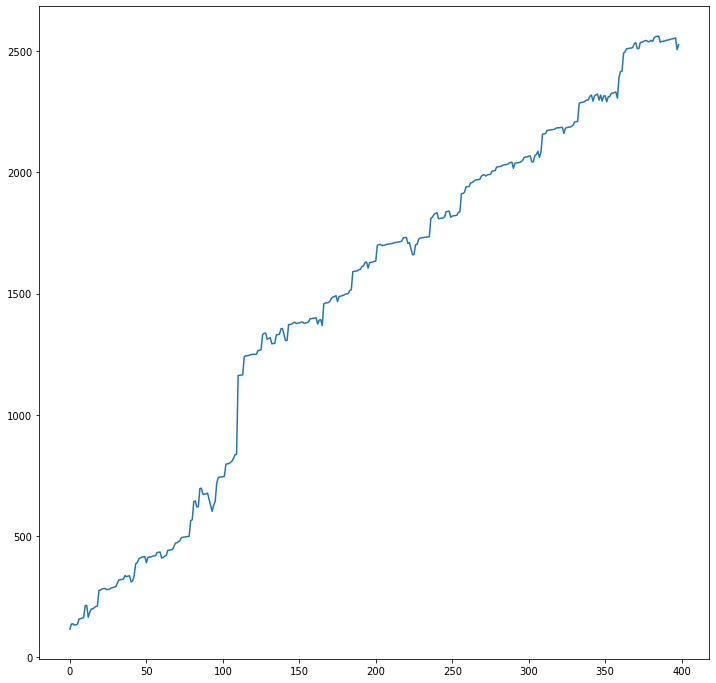

In [14]:
import random
import math
import copy
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 10) for i in range(10)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint")#self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: (int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])))(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    fig = plt.figure(figsize=(12, 12))
    plt.plot(list(range(len(self.score))), self.score)
    plt.show()

  def getHint(self):
    prevObjs = sum(1 for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, (0,0)]
    #debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix((i,j))
          newScore = sum(sum(self.objects[b][1] - (b == "." or 0) for b in a) for a in newObj.matrix) + (prevObjs - 12*newObj.minDistanceToElement((i,j), ["1", "2", newObj.matrix[i][j]]))
          if newScore>tempValues[0]: tempValues = [newScore, (i,j)]
          #debugValues[i][j] = newScore
    #plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    #plt.show()
    return tempValues[1]
  
  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]): continue
            if self.matrix[i][j] in elements: return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(((n[0][0]-1, n[0][1]), (n[0][0], n[0][1]+1), (n[0][0]+1, n[0][1]), (n[0][0], n[0][1]-1))):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    visited = set()
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      visited.add(n)
      for i in ((n[0]-1, n[1]), (n[0], n[1]+1), (n[0]+1, n[1]), (n[0], n[1]-1)):
        if i[0] < 0 or i[0] >= len(self.matrix) or i[1] < 0 or i[1] >= len(self.matrix[0]): continue
        if (not i in visited) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()

**Bot Encoding**

In [97]:
import copy
copyObj = copy.copy(g)

In [98]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['b', 'a', 'a', '2', 'a', '2', 'a', 'a', '3', 'a'],
  ['2', 'a', '2', 'a', '2', 'a', '2', 'a', '2', 'a'],
  ['a', '2', 'a', 'c', 'a', 'b', 'a', 'c', 'a', 'b'],
  ['a', 'c', 'a', '3', 'a', '2', 'a', '2', 'a', 'b'],
  ['b', '2', 'c', '2', '2', 'c', '3', 'a', 'c', '2'],
  ['b', 'a', '2', 'a', 'b', 'a', 'c', 'a', '2', 'a'],
  ['a', 'b', '2', 'c', 'd', '2', 'a', '3', 'a', 'a'],
  ['a', 'b', 'd', 'a', 'a', 'c', 'a', 'd', 'a', '2'],
  ['d', '3', 'b', '2', 'c', 'x', 'b', '2', 'a', 'a'],
  ['a', 'b', 'a', 'a', 'c', '2', 'a', 'a', '2', 'a']],
 'seq': '',
 'turn': 227,
 'score': [-14,
  7,
  10,
  5,
  6,
  7,
  28,
  49,
  50,
  51,
  52,
  53,
  -44,
  -3,
  -2,
  -1,
  4,
  -1,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  20,
  15,
  28,
  23,
  24,
  27,
  28,
  43,
 

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


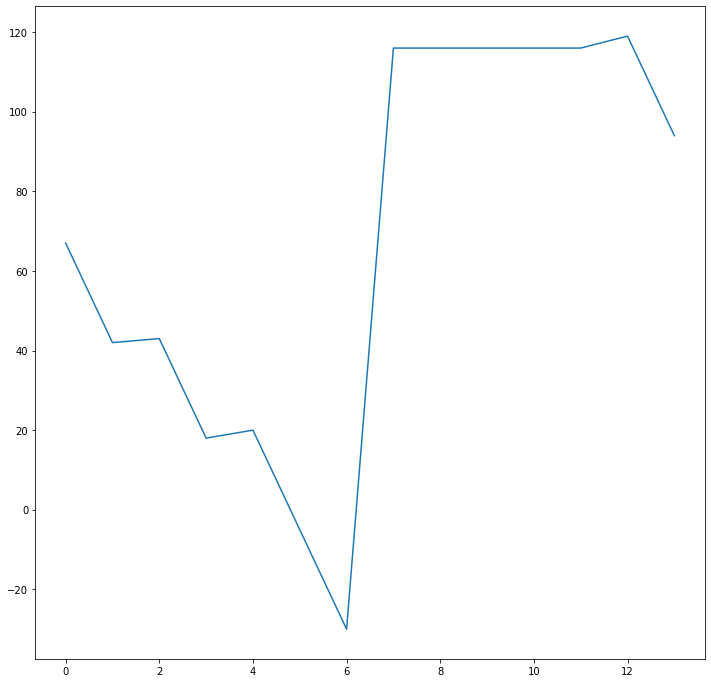

In [ ]:
copyObj.main()